In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np

1. Load in the csv file. 

In [2]:
df = pd.read_csv('aqi_ny.csv')

2. Drop the extra index.

In [3]:
df = df.drop('Unnamed: 0', axis=1)

In [4]:
df

,date,co,no,no2,o3,so2,pm2_5,pm10,nh3,aqi,latitude,longitude,city
0,2020-12-01 05:00:00,373.84,1.50,43.87,8.49,6.86,9.31,11.75,1.30,2,40.7127,-74.006,"New York, NY"
1,2020-12-01 06:00:00,343.80,1.16,37.70,9.39,7.09,8.43,10.47,1.09,1,40.7127,-74.006,"New York, NY"
2,2020-12-01 07:00:00,337.12,1.79,35.99,6.35,7.21,8.55,10.80,1.08,1,40.7127,-74.006,"New York, NY"
3,2020-12-01 08:00:00,337.12,3.38,34.96,3.09,7.63,8.92,11.57,1.08,1,40.7127,-74.006,"New York, NY"
4,2020-12-01 09:00:00,340.46,5.87,33.59,1.16,8.23,9.62,12.64,1.09,1,40.7127,-74.006,"New York, NY"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18056,2022-12-31 13:00:00,821.11,62.58,61.69,0.00,5.48,36.08,44.15,3.39,3,40.7127,-74.006,"New York, NY"
18057,2022-12-31 14:00:00,1028.06,92.09,69.23,0.12,6.56,45.75,56.04,3.96,3,40.7127,-74.006,"New York, NY"
18058,2022-12-31 15:00:00,1134.87,104.61,69.23,0.46,8.11,50.21,61.68,4.12,4,40.7127,-74.006,"New York, NY"
18059,2022-12-31 16:00:00,1121.52,101.92,64.43,0.44,9.42,48.14,59.03,4.18,3,40.7127,-74.006,"New York, NY"


3. Make the date column the index, and get rid of the extra date column so there's not a duplicate.

In [5]:
df.index = pd.to_datetime(df['date'])

In [6]:
df = df.drop('date', axis=1)

In [7]:
pm25 = df['pm2_5']

4. Visualize your data. 

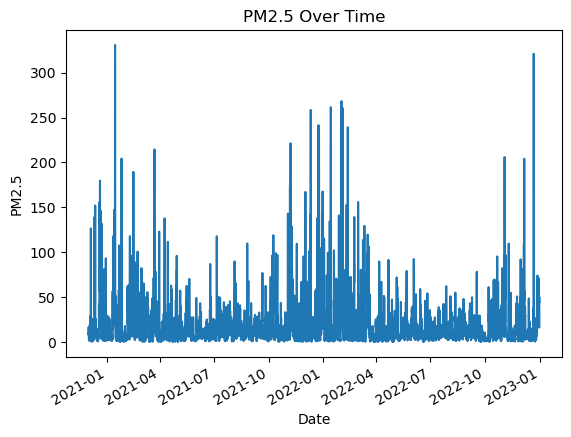

In [8]:
pm25.plot(title= 'PM2.5 Over Time', ylabel = 'PM2.5', xlabel = 'Date');

6. What makes LSTM much better at predicting time series data is that it takes into account a certain amount of values to predict the next one. In this case, the window size is 8, so it is looking at the first 8 values to predict value number 9, next it uses values 2 to 9 to predict 10, and so on. This function gets the data into this format, where X are the predictor values and y is what is being predicted. 

In [9]:
def df_to_X_y(df, window_size=8):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+8]]
        X.append(row)
        label = df_as_np[i+5]
        y.append(label)
    return np.array(X), np.array(y)

7. This shows us the shape of X and y, for both there are 18056 arrays, but X has 8 lists in each array since our window size is 8, and y only has one since we are predicting one value at a time. 

In [10]:
window_size = 8
X, y = df_to_X_y(pm25, window_size)
X.shape, y.shape

((18053, 8, 1), (18053,))

8. Split the data into a training set, a validation set, and a testing set. 

In [11]:
X_train, y_train = X[:12000], y[:12000]
X_val, y_val = X[12000:15000], y[12000:15000]
X_test, y_test = X[15000:], y[15000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((12000, 8, 1), (12000,), (3000, 8, 1), (3000,), (3053, 8, 1), (3053,))

In [12]:
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam 

9. Create the model. For the first layer you have to specify the shape of your model, since the window size is 8 and we only have one predictor the layer is 8 by 1. Next comes 1 LSTM layer, since LSTM is a neural network you have to specify the number of neurons, 32, 64, 128, and 256 are all common. Two dense layers follow the LSTM layer, the last dense layer is responsible for the regression task, and in this case we specify 1 because we want the output to be 1 predicted value.

In [13]:
model1 = Sequential()
model1.add(InputLayer((8,1)))
model1.add(LSTM(64))
model1.add(Dense(8,'relu'))
model1.add(Dense(1,'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


10. Create two callbacks, the first is a checkpoint that saves the best performing model. Just like our XGBoost model, we are using a low learning rate to avoid overfitting so it will be slower. The second is early stopping with patience set equal to 5, so if "val_loss" does not lower for five rounds, the model will stop running. 

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

In [15]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
cp = ModelCheckpoint('model1/', monitor='val_loss', mode='min', save_best_only=True)
cb_list = [es, cp]

In [16]:
model1.compile(loss=MeanSquaredError(), optimizer = Adam(learning_rate=0.0001), metrics=RootMeanSquaredError())

11. Fit the model. The number you choose for your epochs specifies how many times you will run through the data, so the larger the number the longer it will take to run. 

In [17]:
model1.fit(X_train,y_train, validation_data=(X_val,y_val), epochs=50, callbacks=cb_list)

Epoch 1/50
370/375 [============================>.] - ETA: 0s - loss: 975.9042 - root_mean_squared_error: 31.2395

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 6s 13ms/step - loss: 967.5792 - root_mean_squared_error: 31.1059 - val_loss: 96.6662 - val_root_mean_squared_error: 9.8319
Epoch 2/50
369/375 [============================>.] - ETA: 0s - loss: 711.3365 - root_mean_squared_error: 26.6709

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 12ms/step - loss: 709.6847 - root_mean_squared_error: 26.6399 - val_loss: 40.8234 - val_root_mean_squared_error: 6.3893
Epoch 3/50
362/375 [===========================>..] - ETA: 0s - loss: 548.8766 - root_mean_squared_error: 23.4281

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 5s 12ms/step - loss: 545.3887 - root_mean_squared_error: 23.3536 - val_loss: 23.0131 - val_root_mean_squared_error: 4.7972
Epoch 4/50
362/375 [===========================>..] - ETA: 0s - loss: 450.0830 - root_mean_squared_error: 21.2152

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 5s 13ms/step - loss: 445.3234 - root_mean_squared_error: 21.1027 - val_loss: 13.8951 - val_root_mean_squared_error: 3.7276
Epoch 5/50
368/375 [============================>.] - ETA: 0s - loss: 368.6377 - root_mean_squared_error: 19.1999

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 12ms/step - loss: 367.1903 - root_mean_squared_error: 19.1622 - val_loss: 9.5440 - val_root_mean_squared_error: 3.0893
Epoch 6/50
372/375 [============================>.] - ETA: 0s - loss: 309.1582 - root_mean_squared_error: 17.5829

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 5s 12ms/step - loss: 307.0218 - root_mean_squared_error: 17.5220 - val_loss: 6.8520 - val_root_mean_squared_error: 2.6176
Epoch 7/50
373/375 [============================>.] - ETA: 0s - loss: 257.4482 - root_mean_squared_error: 16.0452

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 12ms/step - loss: 260.4237 - root_mean_squared_error: 16.1376 - val_loss: 4.7908 - val_root_mean_squared_error: 2.1888
Epoch 8/50
371/375 [============================>.] - ETA: 0s - loss: 223.7339 - root_mean_squared_error: 14.9577

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 5s 13ms/step - loss: 222.4342 - root_mean_squared_error: 14.9142 - val_loss: 3.5937 - val_root_mean_squared_error: 1.8957
Epoch 9/50
373/375 [============================>.] - ETA: 0s - loss: 189.6632 - root_mean_squared_error: 13.7718

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 5s 13ms/step - loss: 190.9477 - root_mean_squared_error: 13.8184 - val_loss: 2.7410 - val_root_mean_squared_error: 1.6556
Epoch 10/50
364/375 [============================>.] - ETA: 0s - loss: 161.7569 - root_mean_squared_error: 12.7184

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 5s 12ms/step - loss: 164.2525 - root_mean_squared_error: 12.8161 - val_loss: 2.2994 - val_root_mean_squared_error: 1.5164
Epoch 11/50
367/375 [============================>.] - ETA: 0s - loss: 142.2721 - root_mean_squared_error: 11.9278

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 5s 12ms/step - loss: 141.6451 - root_mean_squared_error: 11.9015 - val_loss: 1.8805 - val_root_mean_squared_error: 1.3713
Epoch 12/50
374/375 [============================>.] - ETA: 0s - loss: 122.7788 - root_mean_squared_error: 11.0806

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 5s 13ms/step - loss: 122.4593 - root_mean_squared_error: 11.0661 - val_loss: 1.5841 - val_root_mean_squared_error: 1.2586
Epoch 13/50
367/375 [============================>.] - ETA: 0s - loss: 106.9156 - root_mean_squared_error: 10.3400

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 5s 13ms/step - loss: 106.0359 - root_mean_squared_error: 10.2974 - val_loss: 1.3522 - val_root_mean_squared_error: 1.1628
Epoch 14/50
375/375 [==============================] - ETA: 0s - loss: 91.8891 - root_mean_squared_error: 9.5859

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 5s 13ms/step - loss: 91.8891 - root_mean_squared_error: 9.5859 - val_loss: 1.3120 - val_root_mean_squared_error: 1.1454
Epoch 15/50
370/375 [============================>.] - ETA: 0s - loss: 80.3648 - root_mean_squared_error: 8.9646

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 5s 12ms/step - loss: 80.2903 - root_mean_squared_error: 8.9605 - val_loss: 1.1009 - val_root_mean_squared_error: 1.0492
Epoch 16/50
369/375 [============================>.] - ETA: 0s - loss: 70.5476 - root_mean_squared_error: 8.3993

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 5s 13ms/step - loss: 70.3997 - root_mean_squared_error: 8.3905 - val_loss: 1.0521 - val_root_mean_squared_error: 1.0257
Epoch 17/50
362/375 [===========================>..] - ETA: 0s - loss: 63.6634 - root_mean_squared_error: 7.9789

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 12ms/step - loss: 61.9769 - root_mean_squared_error: 7.8725 - val_loss: 0.9963 - val_root_mean_squared_error: 0.9982
Epoch 18/50
373/375 [============================>.] - ETA: 0s - loss: 54.6223 - root_mean_squared_error: 7.3907

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 5s 13ms/step - loss: 54.3792 - root_mean_squared_error: 7.3742 - val_loss: 0.8761 - val_root_mean_squared_error: 0.9360
Epoch 19/50
362/375 [===========================>..] - ETA: 0s - loss: 49.4694 - root_mean_squared_error: 7.0334

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 5s 13ms/step - loss: 48.0792 - root_mean_squared_error: 6.9339 - val_loss: 0.8304 - val_root_mean_squared_error: 0.9113
Epoch 20/50
374/375 [============================>.] - ETA: 0s - loss: 42.8799 - root_mean_squared_error: 6.5483

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 5s 12ms/step - loss: 42.7668 - root_mean_squared_error: 6.5396 - val_loss: 0.7763 - val_root_mean_squared_error: 0.8811
Epoch 21/50
375/375 [==============================] - 2s 5ms/step - loss: 38.2958 - root_mean_squared_error: 6.1884 - val_loss: 0.7846 - val_root_mean_squared_error: 0.8858
Epoch 22/50
375/375 [==============================] - 2s 4ms/step - loss: 34.1768 - root_mean_squared_error: 5.8461 - val_loss: 0.7767 - val_root_mean_squared_error: 0.8813
Epoch 23/50
375/375 [==============================] - ETA: 0s - loss: 30.6037 - root_mean_squared_error: 5.5321

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 5s 13ms/step - loss: 30.6037 - root_mean_squared_error: 5.5321 - val_loss: 0.7159 - val_root_mean_squared_error: 0.8461
Epoch 24/50
375/375 [==============================] - 2s 5ms/step - loss: 27.4017 - root_mean_squared_error: 5.2347 - val_loss: 0.7181 - val_root_mean_squared_error: 0.8474
Epoch 25/50
374/375 [============================>.] - ETA: 0s - loss: 24.3162 - root_mean_squared_error: 4.9311

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 5s 12ms/step - loss: 24.4691 - root_mean_squared_error: 4.9466 - val_loss: 0.6903 - val_root_mean_squared_error: 0.8309
Epoch 26/50
375/375 [==============================] - 2s 5ms/step - loss: 21.7935 - root_mean_squared_error: 4.6684 - val_loss: 0.7234 - val_root_mean_squared_error: 0.8506
Epoch 27/50
375/375 [==============================] - ETA: 0s - loss: 19.5892 - root_mean_squared_error: 4.4260

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 5s 13ms/step - loss: 19.5892 - root_mean_squared_error: 4.4260 - val_loss: 0.6887 - val_root_mean_squared_error: 0.8299
Epoch 28/50
375/375 [==============================] - 2s 5ms/step - loss: 17.7341 - root_mean_squared_error: 4.2112 - val_loss: 0.6892 - val_root_mean_squared_error: 0.8302
Epoch 29/50
366/375 [============================>.] - ETA: 0s - loss: 16.2078 - root_mean_squared_error: 4.0259

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 5s 12ms/step - loss: 15.8986 - root_mean_squared_error: 3.9873 - val_loss: 0.6443 - val_root_mean_squared_error: 0.8027
Epoch 30/50
375/375 [==============================] - 2s 5ms/step - loss: 14.3867 - root_mean_squared_error: 3.7930 - val_loss: 0.6580 - val_root_mean_squared_error: 0.8111
Epoch 31/50
375/375 [==============================] - 2s 5ms/step - loss: 12.8116 - root_mean_squared_error: 3.5793 - val_loss: 0.6461 - val_root_mean_squared_error: 0.8038
Epoch 32/50
375/375 [==============================] - 2s 6ms/step - loss: 11.6023 - root_mean_squared_error: 3.4062 - val_loss: 0.6800 - val_root_mean_squared_error: 0.8246
Epoch 33/50
374/375 [============================>.] - ETA: 0s - loss: 10.4038 - root_mean_squared_error: 3.2255

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 5s 12ms/step - loss: 10.3770 - root_mean_squared_error: 3.2213 - val_loss: 0.6088 - val_root_mean_squared_error: 0.7802
Epoch 34/50
371/375 [============================>.] - ETA: 0s - loss: 9.3388 - root_mean_squared_error: 3.0559

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 5s 13ms/step - loss: 9.5259 - root_mean_squared_error: 3.0864 - val_loss: 0.6033 - val_root_mean_squared_error: 0.7768
Epoch 35/50
375/375 [==============================] - 2s 5ms/step - loss: 8.5323 - root_mean_squared_error: 2.9210 - val_loss: 0.6234 - val_root_mean_squared_error: 0.7896
Epoch 36/50
375/375 [==============================] - 2s 5ms/step - loss: 7.9521 - root_mean_squared_error: 2.8199 - val_loss: 0.6441 - val_root_mean_squared_error: 0.8025
Epoch 37/50
373/375 [============================>.] - ETA: 0s - loss: 7.0785 - root_mean_squared_error: 2.6605

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 5s 15ms/step - loss: 7.1156 - root_mean_squared_error: 2.6675 - val_loss: 0.5820 - val_root_mean_squared_error: 0.7629
Epoch 38/50
375/375 [==============================] - 2s 5ms/step - loss: 6.5391 - root_mean_squared_error: 2.5572 - val_loss: 0.5940 - val_root_mean_squared_error: 0.7707
Epoch 39/50
375/375 [==============================] - 2s 5ms/step - loss: 6.0862 - root_mean_squared_error: 2.4670 - val_loss: 0.5966 - val_root_mean_squared_error: 0.7724
Epoch 40/50
375/375 [==============================] - ETA: 0s - loss: 5.6191 - root_mean_squared_error: 2.3705

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 5s 13ms/step - loss: 5.6191 - root_mean_squared_error: 2.3705 - val_loss: 0.5542 - val_root_mean_squared_error: 0.7445
Epoch 41/50
375/375 [==============================] - 2s 5ms/step - loss: 5.2494 - root_mean_squared_error: 2.2912 - val_loss: 0.5633 - val_root_mean_squared_error: 0.7505
Epoch 42/50
369/375 [============================>.] - ETA: 0s - loss: 4.8879 - root_mean_squared_error: 2.2109

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 5s 14ms/step - loss: 4.8345 - root_mean_squared_error: 2.1987 - val_loss: 0.5411 - val_root_mean_squared_error: 0.7356
Epoch 43/50
375/375 [==============================] - 2s 5ms/step - loss: 4.6805 - root_mean_squared_error: 2.1634 - val_loss: 0.5696 - val_root_mean_squared_error: 0.7547
Epoch 44/50
367/375 [============================>.] - ETA: 0s - loss: 4.3350 - root_mean_squared_error: 2.0821

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 5s 13ms/step - loss: 4.3372 - root_mean_squared_error: 2.0826 - val_loss: 0.5236 - val_root_mean_squared_error: 0.7236
Epoch 45/50
370/375 [============================>.] - ETA: 0s - loss: 4.1287 - root_mean_squared_error: 2.0319

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 5s 14ms/step - loss: 4.0857 - root_mean_squared_error: 2.0213 - val_loss: 0.5006 - val_root_mean_squared_error: 0.7075
Epoch 46/50
375/375 [==============================] - 2s 5ms/step - loss: 3.7815 - root_mean_squared_error: 1.9446 - val_loss: 0.5234 - val_root_mean_squared_error: 0.7235
Epoch 47/50
375/375 [==============================] - 2s 6ms/step - loss: 3.8480 - root_mean_squared_error: 1.9616 - val_loss: 0.5503 - val_root_mean_squared_error: 0.7418
Epoch 48/50
375/375 [==============================] - 2s 6ms/step - loss: 3.6053 - root_mean_squared_error: 1.8988 - val_loss: 0.5377 - val_root_mean_squared_error: 0.7333
Epoch 49/50
372/375 [============================>.] - ETA: 0s - loss: 3.3555 - root_mean_squared_error: 1.8318

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 5s 13ms/step - loss: 3.3390 - root_mean_squared_error: 1.8273 - val_loss: 0.4978 - val_root_mean_squared_error: 0.7055
Epoch 50/50
371/375 [============================>.] - ETA: 0s - loss: 3.1350 - root_mean_squared_error: 1.7706

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 5s 14ms/step - loss: 3.1081 - root_mean_squared_error: 1.7630 - val_loss: 0.4911 - val_root_mean_squared_error: 0.7008


In [18]:
from keras.models import load_model

12. Load the model so we can work with the best one. 

In [19]:
model1 = load_model('model1/')

13. Calculate the predicted values for the training set and add them to a dataframe with the actuals.

In [20]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

375/375 [==============================] - 1s 2ms/step


,Train Predictions,Actuals
0,10.294749,10.60
1,12.114127,11.92
2,14.814240,15.04
3,16.520330,16.85
4,16.077166,15.64
...,...,...
11995,2.290220,2.45
11996,2.653621,2.90
11997,3.271680,3.48
11998,4.211524,4.54


14. Visualize the data to compare predicted values to the actual values for the training set. As you can see, the model did a very good job of predicting values since the lines are pretty much on top of each other.

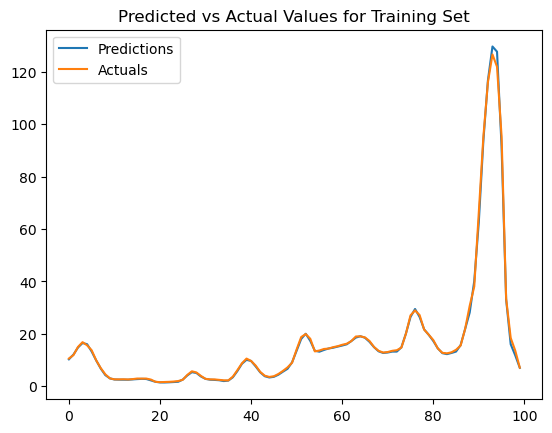

In [21]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][:100])
plt.plot(train_results['Actuals'][:100])
plt.title('Predicted vs Actual Values for Training Set')
plt.legend(['Predictions','Actuals']);

15. Calculate the predicted values for the validation set and add them to a dataframe with the actuals.

In [22]:
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
val_results

94/94 [==============================] - 1s 3ms/step


,Val Predictions,Actuals
0,8.071652,7.60
1,11.380260,11.78
2,10.302791,12.08
3,6.962555,5.95
4,6.689896,6.47
...,...,...
2995,20.151451,20.61
2996,19.369207,19.86
2997,18.330036,18.63
2998,17.846189,17.85


16. Visualize the data to compare predicted values to the actual values for the validation set. Again, it looks like the model did a good job of predicting values. 

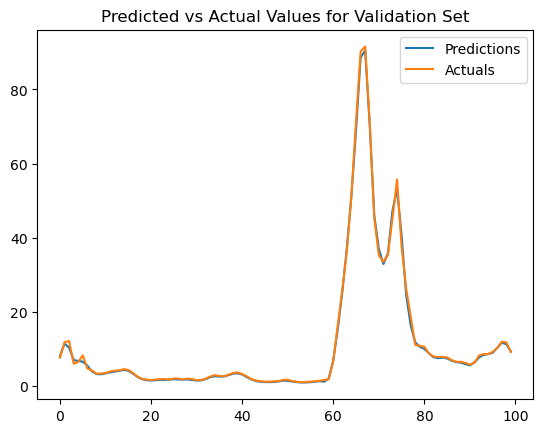

In [23]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])
plt.title('Predicted vs Actual Values for Validation Set')
plt.legend(['Predictions','Actuals']);

17. Calculate the predicted values for the test set and add them to a dataframe along with the actuals.

In [24]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
test_results

96/96 [==============================] - 0s 3ms/step


,Test Predictions,Actuals
0,18.116283,18.85
1,17.197718,16.84
2,17.374121,17.90
3,19.230680,19.42
4,22.954025,22.37
...,...,...
3048,15.704947,16.50
3049,17.820337,17.82
3050,25.369282,24.86
3051,36.077686,36.08


18. Visualize the data to compare predicted values to the actual values for the test set. This time, it looks like the model struggled a bit when predicting those first two larger spikes. But overall, it looks like the model performed well again.  

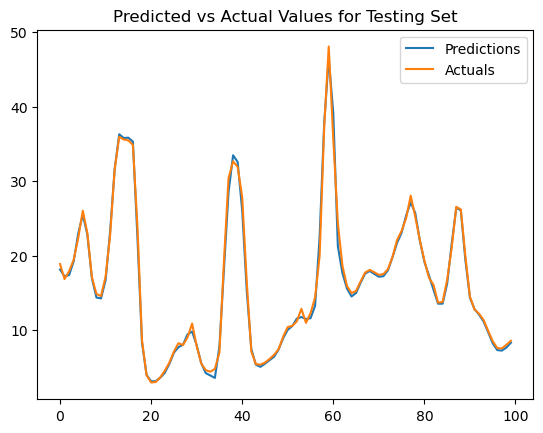

In [25]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])
plt.title('Predicted vs Actual Values for Testing Set')
plt.legend(['Predictions','Actuals']);

In [26]:
from sklearn.metrics import r2_score

19. Calculate the coefficient of determination for the training set, validation set, and testing set. As you can see, the model performed very well, especially when you consider that we did not have to add any extra features like we had to for the XGBoost model. When we tested the XGBoost model's training score with no added features it was .12, so this model performs much better at its most basic level. 

In [27]:
train_r2 = r2_score(train_results['Actuals'],train_results['Train Predictions'])
train_r2

0.9945357315726592

In [28]:
val_r2 = r2_score(val_results['Actuals'],val_results['Val Predictions'])
val_r2

0.9953435590749444

In [29]:
test_r2 = r2_score(test_results['Actuals'],test_results['Test Predictions'])
test_r2

0.9873399362607875

In [30]:
from sklearn.metrics import mean_squared_error 

20. Calculate the Mean Squared Error and the Root Mean Squared Error. The MSE for the XGBoost model's testing set was 40.62, while this model's MSE is much lower at 7.37. 

In [31]:
realVals_train = train_results.Actuals
predictedVals_train = train_results['Train Predictions']
mse_train = mean_squared_error(realVals_train, predictedVals_train)
mse_train

3.93464681906428

In [32]:
realVals_train = train_results.Actuals
predictedVals_train = train_results['Train Predictions']
rmse_train = mean_squared_error(realVals_train, predictedVals_train, squared = False)
rmse_train

1.9835944189940342

In [33]:
realVals_val = val_results.Actuals
predictedVals_val = val_results['Val Predictions']
mse_val = mean_squared_error(realVals_val, predictedVals_val)
mse_val

0.4911127607574381

In [34]:
realVals_val = val_results.Actuals
predictedVals_val = val_results['Val Predictions']
rmse_val = mean_squared_error(realVals_val, predictedVals_val, squared = False)
rmse_val

0.7007943783717433

In [35]:
realVals_test = test_results.Actuals
predictedVals_test = test_results['Test Predictions']
mse_test = mean_squared_error(realVals_test, predictedVals_test)
mse_test

7.378983472158171

In [36]:
realVals_test = test_results.Actuals
predictedVals_test = test_results['Test Predictions']
rmse_test = mean_squared_error(realVals_test, predictedVals_test, squared = False)
rmse_test

2.7164284404633543

21. Create a second model. This time we are adding features to help it get a better sense of how the data progresses with time so that its performance is hopefully improved. As we saw before, this is not as necessary as when you use XGBoost to predict time series data, but we want to try and refine our model. 

In [37]:
pm25_df = pd.DataFrame({'pm2_5':pm25})
pm25_df['seconds'] = pm25_df.index.map(pd.Timestamp.timestamp)
pm25_df

,pm2_5,seconds
date,,
2020-12-01 05:00:00,9.31,1.606799e+09
2020-12-01 06:00:00,8.43,1.606802e+09
2020-12-01 07:00:00,8.55,1.606806e+09
2020-12-01 08:00:00,8.92,1.606810e+09
2020-12-01 09:00:00,9.62,1.606813e+09
...,...,...
2022-12-31 13:00:00,36.08,1.672492e+09
2022-12-31 14:00:00,45.75,1.672495e+09
2022-12-31 15:00:00,50.21,1.672499e+09


22. Use the seconds column to create columns for Day sin, Day cos, Year sin, and Year cos. These features are similar to the lag features that we used for our XGBoost model in that they are there to give a sense of relative time, but these are referred to as cyclical features. 

In [38]:
day = 60*60*24
year = 365.2425*day 

pm25_df['Day sin'] = np.sin(pm25_df['seconds'] * (2*np.pi / day))
pm25_df['Day cos'] = np.cos(pm25_df['seconds'] * (2*np.pi / day))
pm25_df['Year sin'] = np.sin(pm25_df['seconds'] * (2*np.pi / year))
pm25_df['Year cos'] = np.cos(pm25_df['seconds'] * (2*np.pi / year))

In [39]:
pm25_df

,pm2_5,seconds,Day sin,Day cos,Year sin,Year cos
date,,,,,,
2020-12-01 05:00:00,9.31,1.606799e+09,0.965926,2.588190e-01,-0.495857,0.868404
2020-12-01 06:00:00,8.43,1.606802e+09,1.000000,1.086286e-11,-0.495234,0.868759
2020-12-01 07:00:00,8.55,1.606806e+09,0.965926,-2.588190e-01,-0.494612,0.869114
2020-12-01 08:00:00,8.92,1.606810e+09,0.866025,-5.000000e-01,-0.493988,0.869468
2020-12-01 09:00:00,9.62,1.606813e+09,0.707107,-7.071068e-01,-0.493365,0.869822
...,...,...,...,...,...,...
2022-12-31 13:00:00,36.08,1.672492e+09,-0.258819,-9.659258e-01,-0.005347,0.999986
2022-12-31 14:00:00,45.75,1.672495e+09,-0.500000,-8.660254e-01,-0.004630,0.999989
2022-12-31 15:00:00,50.21,1.672499e+09,-0.707107,-7.071068e-01,-0.003914,0.999992


23. Drop the seconds column since it is no longer necessary now that we have created the extra columns. 

In [40]:
aqi_df = pm25_df.drop('seconds', axis=1)

In [41]:
aqi_df

,pm2_5,Day sin,Day cos,Year sin,Year cos
date,,,,,
2020-12-01 05:00:00,9.31,0.965926,2.588190e-01,-0.495857,0.868404
2020-12-01 06:00:00,8.43,1.000000,1.086286e-11,-0.495234,0.868759
2020-12-01 07:00:00,8.55,0.965926,-2.588190e-01,-0.494612,0.869114
2020-12-01 08:00:00,8.92,0.866025,-5.000000e-01,-0.493988,0.869468
2020-12-01 09:00:00,9.62,0.707107,-7.071068e-01,-0.493365,0.869822
...,...,...,...,...,...
2022-12-31 13:00:00,36.08,-0.258819,-9.659258e-01,-0.005347,0.999986
2022-12-31 14:00:00,45.75,-0.500000,-8.660254e-01,-0.004630,0.999989
2022-12-31 15:00:00,50.21,-0.707107,-7.071068e-01,-0.003914,0.999992


24. This is the same function as before, but it makes it so that there are 8 lists in each array since the window size is 8, and each array has 5 values since we have 5 features now (PM2.5, day sin, day cos, year sin, and year cos).

In [42]:
def df_to_X_y2(df, window_size=8):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

In [43]:
X2, y2 = df_to_X_y2(aqi_df)
X2.shape, y2.shape 

((18053, 8, 5), (18053,))

25. Separate the data into a training set, a validation set, and a testing set. 

In [44]:
X2_train, y2_train = X2[:12000], y2[:12000]
X2_val, y2_val = X2[12000:15000], y2[12000:15000]
X2_test, y2_test = X2[15000:], y2[15000:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((12000, 8, 5), (12000,), (3000, 8, 5), (3000,), (3053, 8, 5), (3053,))

26. Standardize the data so that all the values are on a similar scale. 

In [45]:
pm25_training_mean = np.mean(X2_train[:, :, 0])
pm25_training_std = np.std(X2_train[:, :, 0])

def preprocess(X):
    X[:, :, 0] = (X[:, :, 0] - pm25_training_mean) / pm25_training_std
    return X

In [46]:
preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)

array([[[ 7.63055244e-02,  9.65925826e-01,  2.58819045e-01,
         -7.79677220e-01, -6.26181629e-01],
        [ 4.83556901e-02,  1.00000000e+00,  9.43975630e-12,
         -7.80125855e-01, -6.25622610e-01],
        [ 2.51796176e-03,  9.65925826e-01, -2.58819045e-01,
         -7.80574090e-01, -6.25063269e-01],
        ...,
        [ 1.07165798e-02,  5.00000000e-01, -8.66025404e-01,
         -7.81916387e-01, -6.23383320e-01],
        [-6.41889762e-02,  2.58819045e-01, -9.65925826e-01,
         -7.82363017e-01, -6.22822696e-01],
        [-2.46865437e-02,  1.20031004e-11, -1.00000000e+00,
         -7.82809244e-01, -6.22261752e-01]],

       [[ 4.83556901e-02,  1.00000000e+00,  9.43975630e-12,
         -7.80125855e-01, -6.25622610e-01],
        [ 2.51796176e-03,  9.65925826e-01, -2.58819045e-01,
         -7.80574090e-01, -6.25063269e-01],
        [-2.65498660e-02,  8.66025404e-01, -5.00000000e-01,
         -7.81021924e-01, -6.24503606e-01],
        ...,
        [-6.41889762e-02,  2.5881904

27. Create the model, everything stays the same as the first attempt but the InputLayer since the dimensions have now changed because we added those extra time features. 

In [47]:
model2 = Sequential()
model2.add(InputLayer((8, 5)))
model2.add(LSTM(64))
model2.add(Dense(8,'relu'))
model2.add(Dense(1,'linear'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                17920     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________


28. Create the two callbacks once again.

In [48]:
es2 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
cp2 = ModelCheckpoint('model2/', monitor='val_loss', mode='min', save_best_only=True)
cb_list2 = [es2, cp2]

In [49]:
model2.compile(loss=MeanSquaredError(), optimizer = Adam(learning_rate=0.0001), metrics=RootMeanSquaredError())

29. Fit the model.

In [50]:
model2.fit(X2_train,y2_train, validation_data=(X2_val,y2_val), epochs=50, callbacks=cb_list2)

Epoch 1/50
361/375 [===========================>..] - ETA: 0s - loss: 963.1251 - root_mean_squared_error: 31.0343

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 6s 13ms/step - loss: 967.9074 - root_mean_squared_error: 31.1112 - val_loss: 209.1398 - val_root_mean_squared_error: 14.4617
Epoch 2/50
359/375 [===========================>..] - ETA: 0s - loss: 688.7014 - root_mean_squared_error: 26.2431

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 12ms/step - loss: 682.6810 - root_mean_squared_error: 26.1282 - val_loss: 81.1943 - val_root_mean_squared_error: 9.0108
Epoch 3/50
363/375 [============================>.] - ETA: 0s - loss: 583.2553 - root_mean_squared_error: 24.1507

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 4s 12ms/step - loss: 583.9327 - root_mean_squared_error: 24.1647 - val_loss: 79.5917 - val_root_mean_squared_error: 8.9214
Epoch 4/50
369/375 [============================>.] - ETA: 0s - loss: 525.7845 - root_mean_squared_error: 22.9300

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 4s 12ms/step - loss: 523.6971 - root_mean_squared_error: 22.8844 - val_loss: 70.8432 - val_root_mean_squared_error: 8.4168
Epoch 5/50
370/375 [============================>.] - ETA: 0s - loss: 470.6666 - root_mean_squared_error: 21.6949

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 12ms/step - loss: 467.3805 - root_mean_squared_error: 21.6190 - val_loss: 59.7601 - val_root_mean_squared_error: 7.7305
Epoch 6/50
374/375 [============================>.] - ETA: 0s - loss: 411.7500 - root_mean_squared_error: 20.2916

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 4s 12ms/step - loss: 411.6430 - root_mean_squared_error: 20.2890 - val_loss: 49.3684 - val_root_mean_squared_error: 7.0263
Epoch 7/50
361/375 [===========================>..] - ETA: 0s - loss: 364.0977 - root_mean_squared_error: 19.0813

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 13ms/step - loss: 361.6798 - root_mean_squared_error: 19.0179 - val_loss: 44.0695 - val_root_mean_squared_error: 6.6385
Epoch 8/50
374/375 [============================>.] - ETA: 0s - loss: 319.3165 - root_mean_squared_error: 17.8694

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 4s 12ms/step - loss: 318.5221 - root_mean_squared_error: 17.8472 - val_loss: 38.1359 - val_root_mean_squared_error: 6.1754
Epoch 9/50
368/375 [============================>.] - ETA: 0s - loss: 279.1569 - root_mean_squared_error: 16.7080

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 13ms/step - loss: 280.9404 - root_mean_squared_error: 16.7613 - val_loss: 34.9144 - val_root_mean_squared_error: 5.9088
Epoch 10/50
373/375 [============================>.] - ETA: 0s - loss: 248.0121 - root_mean_squared_error: 15.7484

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 4s 12ms/step - loss: 247.7145 - root_mean_squared_error: 15.7389 - val_loss: 29.5454 - val_root_mean_squared_error: 5.4356
Epoch 11/50
368/375 [============================>.] - ETA: 0s - loss: 220.6580 - root_mean_squared_error: 14.8546

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 13ms/step - loss: 218.4178 - root_mean_squared_error: 14.7790 - val_loss: 26.5282 - val_root_mean_squared_error: 5.1506
Epoch 12/50
371/375 [============================>.] - ETA: 0s - loss: 192.8368 - root_mean_squared_error: 13.8866

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 4s 12ms/step - loss: 193.8460 - root_mean_squared_error: 13.9229 - val_loss: 24.1401 - val_root_mean_squared_error: 4.9133
Epoch 13/50
368/375 [============================>.] - ETA: 0s - loss: 175.6998 - root_mean_squared_error: 13.2552

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 14ms/step - loss: 173.4391 - root_mean_squared_error: 13.1696 - val_loss: 21.9252 - val_root_mean_squared_error: 4.6824
Epoch 14/50
366/375 [============================>.] - ETA: 0s - loss: 158.1141 - root_mean_squared_error: 12.5743

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 4s 12ms/step - loss: 155.8103 - root_mean_squared_error: 12.4824 - val_loss: 19.7788 - val_root_mean_squared_error: 4.4473
Epoch 15/50
374/375 [============================>.] - ETA: 0s - loss: 140.4077 - root_mean_squared_error: 11.8494

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 13ms/step - loss: 140.1275 - root_mean_squared_error: 11.8375 - val_loss: 17.3683 - val_root_mean_squared_error: 4.1675
Epoch 16/50
362/375 [===========================>..] - ETA: 0s - loss: 128.6788 - root_mean_squared_error: 11.3437

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 4s 12ms/step - loss: 126.1662 - root_mean_squared_error: 11.2324 - val_loss: 15.7200 - val_root_mean_squared_error: 3.9648
Epoch 17/50
367/375 [============================>.] - ETA: 0s - loss: 113.2340 - root_mean_squared_error: 10.6411

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 13ms/step - loss: 114.1190 - root_mean_squared_error: 10.6826 - val_loss: 14.7796 - val_root_mean_squared_error: 3.8444
Epoch 18/50
375/375 [==============================] - ETA: 0s - loss: 103.7433 - root_mean_squared_error: 10.1854

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 4s 12ms/step - loss: 103.7433 - root_mean_squared_error: 10.1854 - val_loss: 13.5325 - val_root_mean_squared_error: 3.6787
Epoch 19/50
366/375 [============================>.] - ETA: 0s - loss: 95.0645 - root_mean_squared_error: 9.7501

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 13ms/step - loss: 94.5586 - root_mean_squared_error: 9.7241 - val_loss: 12.2015 - val_root_mean_squared_error: 3.4931
Epoch 20/50
361/375 [===========================>..] - ETA: 0s - loss: 84.1532 - root_mean_squared_error: 9.1735

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 12ms/step - loss: 86.6034 - root_mean_squared_error: 9.3061 - val_loss: 11.6438 - val_root_mean_squared_error: 3.4123
Epoch 21/50
371/375 [============================>.] - ETA: 0s - loss: 79.4152 - root_mean_squared_error: 8.9115

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 12ms/step - loss: 79.4134 - root_mean_squared_error: 8.9114 - val_loss: 10.9715 - val_root_mean_squared_error: 3.3123
Epoch 22/50
365/375 [============================>.] - ETA: 0s - loss: 73.2430 - root_mean_squared_error: 8.5582

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 13ms/step - loss: 73.0961 - root_mean_squared_error: 8.5496 - val_loss: 10.6033 - val_root_mean_squared_error: 3.2563
Epoch 23/50
365/375 [============================>.] - ETA: 0s - loss: 65.1707 - root_mean_squared_error: 8.0728

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 13ms/step - loss: 67.4034 - root_mean_squared_error: 8.2100 - val_loss: 10.0756 - val_root_mean_squared_error: 3.1742
Epoch 24/50
367/375 [============================>.] - ETA: 0s - loss: 63.1183 - root_mean_squared_error: 7.9447

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 4s 12ms/step - loss: 62.5819 - root_mean_squared_error: 7.9109 - val_loss: 9.5645 - val_root_mean_squared_error: 3.0926
Epoch 25/50
375/375 [==============================] - ETA: 0s - loss: 58.4405 - root_mean_squared_error: 7.6446

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 13ms/step - loss: 58.4405 - root_mean_squared_error: 7.6446 - val_loss: 9.4882 - val_root_mean_squared_error: 3.0803
Epoch 26/50
368/375 [============================>.] - ETA: 0s - loss: 55.5000 - root_mean_squared_error: 7.4498

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 12ms/step - loss: 54.7338 - root_mean_squared_error: 7.3982 - val_loss: 9.2393 - val_root_mean_squared_error: 3.0396
Epoch 27/50
372/375 [============================>.] - ETA: 0s - loss: 51.8145 - root_mean_squared_error: 7.1982

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 13ms/step - loss: 51.5593 - root_mean_squared_error: 7.1805 - val_loss: 8.9590 - val_root_mean_squared_error: 2.9932
Epoch 28/50
366/375 [============================>.] - ETA: 0s - loss: 49.3261 - root_mean_squared_error: 7.0233

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 12ms/step - loss: 48.8479 - root_mean_squared_error: 6.9891 - val_loss: 8.8818 - val_root_mean_squared_error: 2.9802
Epoch 29/50
364/375 [============================>.] - ETA: 0s - loss: 45.0457 - root_mean_squared_error: 6.7116

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 13ms/step - loss: 46.4255 - root_mean_squared_error: 6.8136 - val_loss: 8.7477 - val_root_mean_squared_error: 2.9576
Epoch 30/50
372/375 [============================>.] - ETA: 0s - loss: 44.4496 - root_mean_squared_error: 6.6671

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 4s 12ms/step - loss: 44.2163 - root_mean_squared_error: 6.6495 - val_loss: 8.6510 - val_root_mean_squared_error: 2.9413
Epoch 31/50
364/375 [============================>.] - ETA: 0s - loss: 42.4180 - root_mean_squared_error: 6.5129

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 13ms/step - loss: 42.3880 - root_mean_squared_error: 6.5106 - val_loss: 8.6300 - val_root_mean_squared_error: 2.9377
Epoch 32/50
361/375 [===========================>..] - ETA: 0s - loss: 40.6194 - root_mean_squared_error: 6.3733

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 12ms/step - loss: 40.7015 - root_mean_squared_error: 6.3798 - val_loss: 8.6287 - val_root_mean_squared_error: 2.9375
Epoch 33/50
374/375 [============================>.] - ETA: 0s - loss: 38.9987 - root_mean_squared_error: 6.2449

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 13ms/step - loss: 38.9254 - root_mean_squared_error: 6.2390 - val_loss: 8.5841 - val_root_mean_squared_error: 2.9299
Epoch 34/50
373/375 [============================>.] - ETA: 0s - loss: 37.7368 - root_mean_squared_error: 6.1430

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 4s 12ms/step - loss: 37.5829 - root_mean_squared_error: 6.1305 - val_loss: 8.3334 - val_root_mean_squared_error: 2.8868
Epoch 35/50
375/375 [==============================] - 2s 5ms/step - loss: 36.2452 - root_mean_squared_error: 6.0204 - val_loss: 8.4313 - val_root_mean_squared_error: 2.9037
Epoch 36/50
375/375 [==============================] - ETA: 0s - loss: 35.0709 - root_mean_squared_error: 5.9221

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 13ms/step - loss: 35.0709 - root_mean_squared_error: 5.9221 - val_loss: 8.2453 - val_root_mean_squared_error: 2.8715
Epoch 37/50
373/375 [============================>.] - ETA: 0s - loss: 34.2205 - root_mean_squared_error: 5.8498

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 12ms/step - loss: 34.0859 - root_mean_squared_error: 5.8383 - val_loss: 8.2430 - val_root_mean_squared_error: 2.8711
Epoch 38/50
374/375 [============================>.] - ETA: 0s - loss: 33.0649 - root_mean_squared_error: 5.7502

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 14ms/step - loss: 33.0017 - root_mean_squared_error: 5.7447 - val_loss: 8.2218 - val_root_mean_squared_error: 2.8674
Epoch 39/50
362/375 [===========================>..] - ETA: 0s - loss: 31.9728 - root_mean_squared_error: 5.6544

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 12ms/step - loss: 32.0924 - root_mean_squared_error: 5.6650 - val_loss: 8.0229 - val_root_mean_squared_error: 2.8325
Epoch 40/50
375/375 [==============================] - 2s 5ms/step - loss: 31.3623 - root_mean_squared_error: 5.6002 - val_loss: 8.1386 - val_root_mean_squared_error: 2.8528
Epoch 41/50
375/375 [==============================] - 2s 5ms/step - loss: 30.6005 - root_mean_squared_error: 5.5318 - val_loss: 8.1261 - val_root_mean_squared_error: 2.8506
Epoch 42/50
375/375 [==============================] - 2s 5ms/step - loss: 29.7388 - root_mean_squared_error: 5.4533 - val_loss: 8.1071 - val_root_mean_squared_error: 2.8473
Epoch 43/50
374/375 [============================>.] - ETA: 0s - loss: 29.3165 - root_mean_squared_error: 5.4145

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 13ms/step - loss: 29.2519 - root_mean_squared_error: 5.4085 - val_loss: 7.9281 - val_root_mean_squared_error: 2.8157
Epoch 44/50
375/375 [==============================] - 2s 5ms/step - loss: 28.5912 - root_mean_squared_error: 5.3471 - val_loss: 8.0434 - val_root_mean_squared_error: 2.8361
Epoch 45/50
375/375 [==============================] - ETA: 0s - loss: 28.1347 - root_mean_squared_error: 5.3042

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 4s 12ms/step - loss: 28.1347 - root_mean_squared_error: 5.3042 - val_loss: 7.8765 - val_root_mean_squared_error: 2.8065
Epoch 46/50
375/375 [==============================] - 2s 6ms/step - loss: 27.5133 - root_mean_squared_error: 5.2453 - val_loss: 7.9055 - val_root_mean_squared_error: 2.8117
Epoch 47/50
373/375 [============================>.] - ETA: 0s - loss: 26.7699 - root_mean_squared_error: 5.1740

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 13ms/step - loss: 27.0951 - root_mean_squared_error: 5.2053 - val_loss: 7.8046 - val_root_mean_squared_error: 2.7937
Epoch 48/50
375/375 [==============================] - 2s 5ms/step - loss: 26.6538 - root_mean_squared_error: 5.1627 - val_loss: 7.8561 - val_root_mean_squared_error: 2.8029
Epoch 49/50
370/375 [============================>.] - ETA: 0s - loss: 25.7460 - root_mean_squared_error: 5.0741

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 12ms/step - loss: 26.2093 - root_mean_squared_error: 5.1195 - val_loss: 7.7799 - val_root_mean_squared_error: 2.7892
Epoch 50/50
375/375 [==============================] - 2s 5ms/step - loss: 25.8809 - root_mean_squared_error: 5.0873 - val_loss: 7.8105 - val_root_mean_squared_error: 2.7947


30. Load the model so we can work with the best one. 

In [51]:
model2 = load_model('model2/')

31. Calculate the predicted values for the training set and add them to a dataframe along with the actuals.

In [52]:
train_predictions2 = model2.predict(X2_train).flatten()
train_results2 = pd.DataFrame(data={'Train Predictions': train_predictions2, 'Actuals': y2_train})
train_results2

375/375 [==============================] - 1s 2ms/step


,Train Predictions,Actuals
0,18.372450,16.85
1,16.641527,15.64
2,12.521891,13.76
3,11.345402,9.90
4,6.865012,6.93
...,...,...
11995,4.074801,4.54
11996,5.559284,5.91
11997,7.155097,7.60
11998,9.199500,11.78


32. Visualize the data to compare predicted values to the actual values for the training set. Again, the model did a pretty good job of predicting values since the lines are pretty close together, but it seems like it had a harder time predicting the larger spikes since the prediction line is lower than the actual line. 

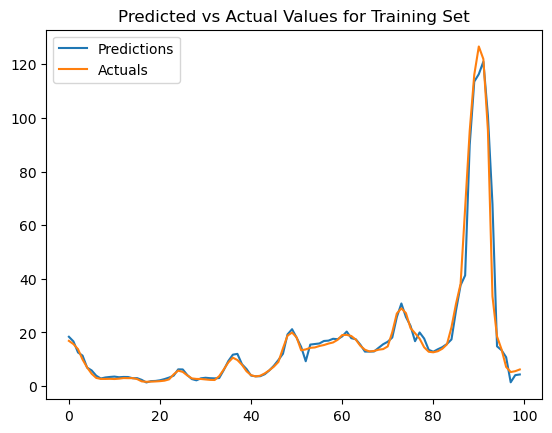

In [53]:
plt.plot(train_results2['Train Predictions'][:100])
plt.plot(train_results2['Actuals'][:100])
plt.title('Predicted vs Actual Values for Training Set')
plt.legend(['Predictions','Actuals']);

33. Calculate the predicted values for the validation set and add them to a dataframe along with the actuals.

In [54]:
val_predictions2 = model2.predict(X2_val).flatten()
val_results2 = pd.DataFrame(data={'Val Predictions': val_predictions2, 'Actuals': y2_val})
val_results2

94/94 [==============================] - 1s 2ms/step


,Val Predictions,Actuals
0,11.466919,5.95
1,1.406476,6.47
2,8.134508,8.21
3,8.679008,4.67
4,2.221463,4.16
...,...,...
2995,17.637659,17.85
2996,17.589710,18.36
2997,19.083309,18.85
2998,18.999483,16.84


34. Visualize the data to compare predicted values to the actual values for the validation set. For this set, it looks like the model did a little better at predicting that larger spike.

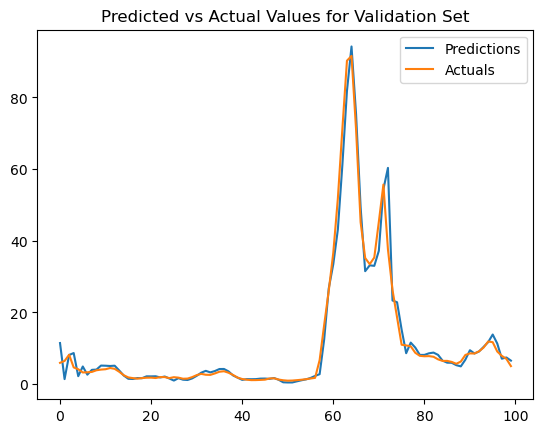

In [55]:
plt.plot(val_results2['Val Predictions'][:100])
plt.plot(val_results2['Actuals'][:100])
plt.title('Predicted vs Actual Values for Validation Set')
plt.legend(['Predictions','Actuals']);

35. Calculate the predicted values for the training set and add them to a dataframe along with the actuals.

In [56]:
test_predictions2 = model2.predict(X2_test).flatten()
test_results2 = pd.DataFrame(data={'Test Predictions': test_predictions2, 'Actuals': y2_test})
test_results2

96/96 [==============================] - 0s 2ms/step


,Test Predictions,Actuals
0,19.863728,19.42
1,20.534004,22.37
2,24.925224,26.01
3,27.821531,23.03
4,19.943226,17.09
...,...,...
3048,33.256470,36.08
3049,44.069641,45.75
3050,47.742439,50.21
3051,45.641624,48.14


36. Visualize the data to compare predicted values to the actual values for the testing set. For this set, it looks like the model's predictions overshot the actuals for the larger spikes.

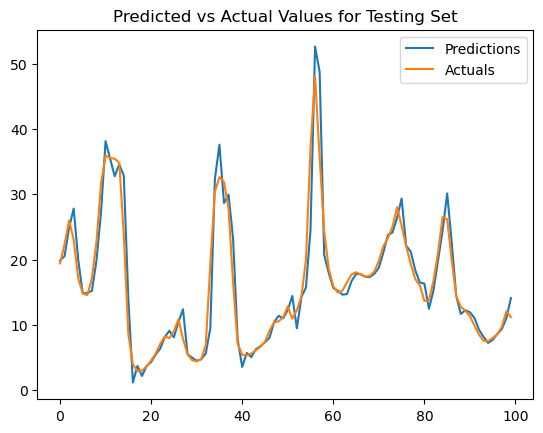

In [57]:
plt.plot(test_results2['Test Predictions'][:100])
plt.plot(test_results2['Actuals'][:100])
plt.title('Predicted vs Actual Values for Testing Set')
plt.legend(['Predictions','Actuals']);

37. Calculate the coefficient of determination for the training set, validation set, and testing set. As you can see, in general the model performed well, though it did not perform as well as that first model. The first model's values for training, validation, and testing were .99, .99, and .98 respectively, and now they are .96, .92, and .96. If you average all three scores for each model you get .98 and .93 respectively, so in general the second model did not improve. In this case, adding time features did not improve the model which suggests that they are not as necessary for predicting time series data with a LSTM model as compared to a XGBoost model. 

In [58]:
train2_r2 = r2_score(train_results2['Actuals'],train_results2['Train Predictions'])
train2_r2

0.9643338417417432

In [59]:
val2_r2 = r2_score(val_results2['Actuals'],val_results2['Val Predictions'])
val2_r2

0.9262602883123824

In [60]:
test2_r2 = r2_score(test_results2['Actuals'],test_results2['Test Predictions'])
test2_r2

0.9624305022469802

38. Calculate the Mean Squared Error and the Root Mean Squared Error. As you can see, all three values are larger than the MSE values from the last model. This model's MSE for the testing set is 21.93, which although it is lower than the first model, it is still better than the XGBoost model's MSE of 40.62. 

In [61]:
realVals_train2 = train_results2.Actuals
predictedVals_train2 = train_results2['Train Predictions']
mse_train2 = mean_squared_error(realVals_train2, predictedVals_train2)
mse_train2

25.68233449262368

In [62]:
realVals_train2 = train_results2.Actuals
predictedVals_train2 = train_results2['Train Predictions']
rmse_train2 = mean_squared_error(realVals_train2, predictedVals_train2, squared = False)
rmse_train2

5.0677741161799705

In [63]:
realVals_val2 = val_results2.Actuals
predictedVals_val2 = val_results2['Val Predictions']
mse_val2 = mean_squared_error(realVals_val2, predictedVals_val2)
mse_val2

7.779916228579169

In [64]:
realVals_val2 = val_results2.Actuals
predictedVals_val2 = val_results2['Val Predictions']
rmse_val2 = mean_squared_error(realVals_val2, predictedVals_val2, squared = False)
rmse_val2

2.789250119401121

In [65]:
realVals_test2 = test_results2.Actuals
predictedVals_test2 = test_results2['Test Predictions']
mse_test2 = mean_squared_error(realVals_test2, predictedVals_test2)
mse_test2

21.934435809025803

In [66]:
realVals_test2 = test_results2.Actuals
predictedVals_test2 = test_results2['Test Predictions']
rmse_test2 = mean_squared_error(realVals_test2, predictedVals_test2, squared = False)
rmse_test2

4.683421378546436